In [3]:
#   ______                                       ___     
#  /\__  _\                                    /'___`\   
#  \/_/\ \/    __     _ __    __     __       /\_\ /\ \  
#     \ \ \  /'__`\  /\`'__\/'__`\ /'__`\     \/_/// /__ 
#      \ \ \/\ \L\.\_\ \ \//\  __//\ \L\.\_      // /_\ \
#       \ \_\ \__/.\_\\ \_\\ \____\ \__/.\_\    /\______/
#        \/_/\/__/\/_/ \/_/ \/____/\/__/\/_/    \/_____/ 
#                                                                                                     

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
import matplotlib.animation as anim

## Punto 1. 

In [183]:
x_1 = np.linspace(-1, 31, 5000)
y_1 = np.linspace(-2, 36, 5000)

x, y = np.meshgrid(x_1, y_1)
f = 5*exp(-0.01*((x-15)**2 + (y-20)**2)) - 2*exp(-0.08*((x-20)**2 + (y-15)**2)) + 3*exp(-0.08*((x-25)**2 + (y-10)**2)) + 2*exp(-0.1*((x-10)**2 + (y-10)**2)) - 2*exp(-0.5*((x-5)**2 + (y-10)**2)) - 4*exp(-0.1*((x-15)**2 + (y-5)**2)) - 2*exp(-0.5*((x-8)**2 + (y-25)**2)) - 2*exp(-0.5*((x-21)**2 + (y-25)**2)) + 2*exp(-0.5*((x-25)**2 + (y-16)**2)) + 2*exp(-0.5*((x-5)**2 + (y-14)**2))

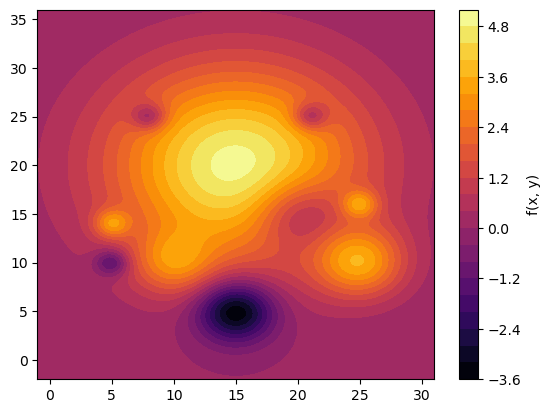

In [184]:
plt.contourf(x, y, f, levels=25, cmap="inferno")
plt.colorbar(label='f(x, y)')

In [192]:
opti = Opti()
x1 = opti.variable()
y1 = opti.variable()
f_ = 5*exp(-0.01*((x1-15)**2 + (y1-20)**2)) - 2*exp(-0.08*((x1-20)**2 + (y1-15)**2)) + 3*exp(-0.08*((x1-25)**2 + (y1-10)**2)) + 2*exp(-0.1*((x1-10)**2 + (y1-10)**2)) - 2*exp(-0.5*((x1-5)**2 + (y1-10)**2)) - 4*exp(-0.1*((x1-15)**2 + (y1-5)**2)) - 2*exp(-0.5*((x1-8)**2 + (y1-25)**2)) - 2*exp(-0.5*((x1-21)**2 + (y1-25)**2)) + 2*exp(-0.5*((x1-25)**2 + (y1-16)**2)) + 2*exp(-0.5*((x1-5)**2 + (y1-14)**2))


initial = [(15,20),(25,10),(25,16),(10,10),(5,14)]
valores = []
opt_1 = dict(print_time=False)
opt_2 = dict(print_level=0)


opti.minimize(-f_)
opti.solver('ipopt', opt_1, opt_2)
opti.subject_to(x1>=-1)
opti.subject_to(31>=x1)
opti.subject_to(y1>=-2)
opti.subject_to(36>=y1)

for i in initial:
    xi, yi = i
    opti.set_initial(x1, xi)
    opti.set_initial(y1, yi)
    sol = opti.solve()
    valores.append((sol.value(x1),sol.value(y1)))

[(14.784715075613162, 20.215098377329646), (24.77990842945663, 10.220207225026883), (24.946150398135956, 16.003689399118254), (10.41742535052925, 10.946127705339617), (5.151029152094572, 14.066188866220534)]


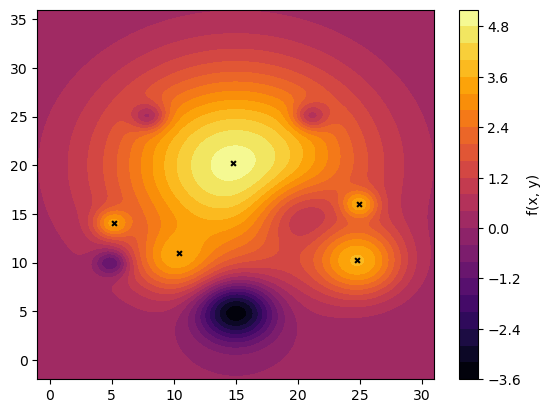

In [193]:
print(valores)
plt.contourf(x, y, f, levels=25, cmap="inferno")
plt.colorbar(label='f(x, y)')
for val in valores:
    plt.scatter(val[0], val[1], marker='x', color='black', s=12)



## Punto 2. 

a.

In [80]:
Q1 = 900
Q2 = 500
Q3 = 3
R1 = 3
R2 = 3

nx = 3
nu = 2
x = MX.sym('x', nx)
u = MX.sym('u', nu)

f = Function('f', [x, u], [vertcat(u[0]*cos(x[2]), u[0]*sin(x[2]), u[1])])

dt = 0.2
N = 10

int_opt = {"number_of_finite_elements":1, "tf":dt }


integral = integrator('intg', 'rk', {'x': x, 'p': u, 'ode': f(x, u)}, int_opt)
respuesta = integral(x0=x, p=u)
F = Function('F', [x, u], [respuesta['xf']])

In [81]:
opti = Opti()
X = opti.variable(nx, N+1)
U = opti.variable(nu, N)
x_p = X[0, :]
y_p = X[1, :]
opti.subject_to(opti.bounded(0, x_p, 2))
opti.subject_to(opti.bounded(0, y_p, 2))

a = X[2, :]

v = U[0, :]
w = U[1, :]
opti.subject_to(opti.bounded(-0.6, v, 0.6))
opti.subject_to(opti.bounded(-pi*0.25, w, pi*0.25))



for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[:, k]))
    
x0 = opti.parameter(nx)   
opti.subject_to(X[:, 0] == x0)

xr = np.array([1.5, 1.5, 0])

funcion = Q1 * sumsqr(x_p - xr[0]) + Q2 * sumsqr(y_p - xr[1]) + Q3 * sumsqr(a - xr[2]) + R1 * sumsqr(v) + R2 * sumsqr(w)
opti.minimize(funcion)
opti.set_value(x0, [0, 0, 0])


opti.solver('ipopt', {"print_time":False}, {"print_level":0})
sol = opti.solve()
_mpc_ = opti.to_function('mpc_step', [x0, opti.x, opti.lam_g], [U[:, 0], opti.x, opti.lam_g])
u = sol.value(U[:, 0])
x = sol.value(opti.x)
lam = sol.value(opti.lam_g)


val_x = DM.zeros(nx, 40)
val_u = DM.zeros(nu, 40)
x_i = vertcat(0, 0, 0)

for i in range(40):
    val_x[:, i] = x_i
    val_u[:, i] = u
    x_i = F(x_i, u)
    [u, x, lam] = _mpc_(x_i, x, lam)
    
val_x_ = np.squeeze(val_x[0,:])
val_y_ = np.squeeze(val_x[1,:])
val_u1 = np.squeeze(val_u[0,:])
val_u2 = np.squeeze(val_u[1,:])

<IPython.core.display.Javascript object>


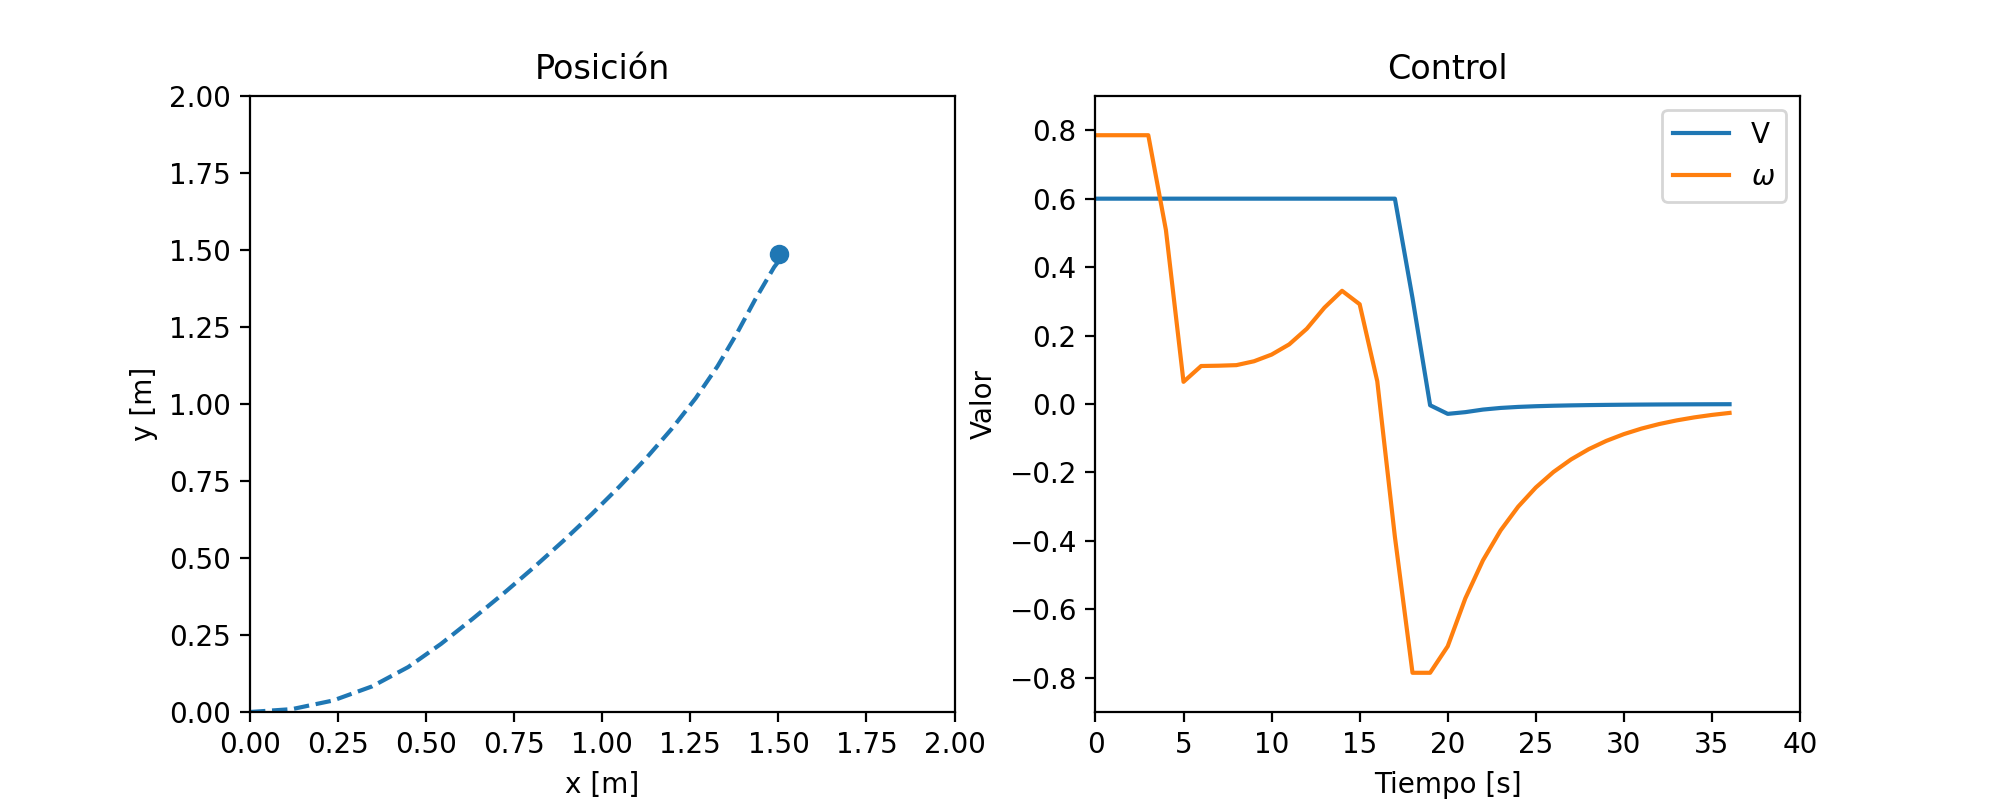

In [82]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def update(i):
    ax.clear()
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.plot(val_x_[:i], val_y_[:i],linestyle="dashed" )
    ax.scatter(val_x_[i], val_y_[i])
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_title("Posición")
    ax1.clear()
    ax1.set_xlim(0, 40)
    ax1.set_ylim(-0.9, 0.9)
    ax1.plot(val_u1[:i], label = "V")
    ax1.plot(val_u2[:i], label="$\omega$")
    ax1.legend()
    ax1.set_xlabel("Tiempo [s]")
    ax1.set_ylabel("Valor")
    ax1.set_title("Control")
    

Animation = anim.FuncAnimation(fig, update, frames=len(val_x_))

b. Punto en $[1,0.4,10]$

In [83]:
xr = np.array([1, 0.4, 10])

funcion = Q1 * sumsqr(x_p - xr[0]) + Q2 * sumsqr(y_p - xr[1]) + Q3 * sumsqr(a - xr[2]) + R1 * sumsqr(v) + R2 * sumsqr(w)
opti.minimize(funcion)
opti.set_value(x0, [0, 0, 0])


opti.solver('ipopt', {"print_time":False}, {"print_level":0})
sol = opti.solve()
_mpc_ = opti.to_function('mpc_step', [x0, opti.x, opti.lam_g], [U[:, 0], opti.x, opti.lam_g])
u = sol.value(U[:, 0])
x = sol.value(opti.x)
lam = sol.value(opti.lam_g)


val_x = DM.zeros(nx, 40)
val_u = DM.zeros(nu, 40)
x_i = vertcat(0, 0, 0)

for i in range(40):
    val_x[:, i] = x_i
    val_u[:, i] = u
    x_i = F(x_i, u)
    [u, x, lam] = _mpc_(x_i, x, lam)
    
val_x_ = np.squeeze(val_x[0,:])
val_y_ = np.squeeze(val_x[1,:])
val_u1 = np.squeeze(val_u[0,:])
val_u2 = np.squeeze(val_u[1,:])

<IPython.core.display.Javascript object>


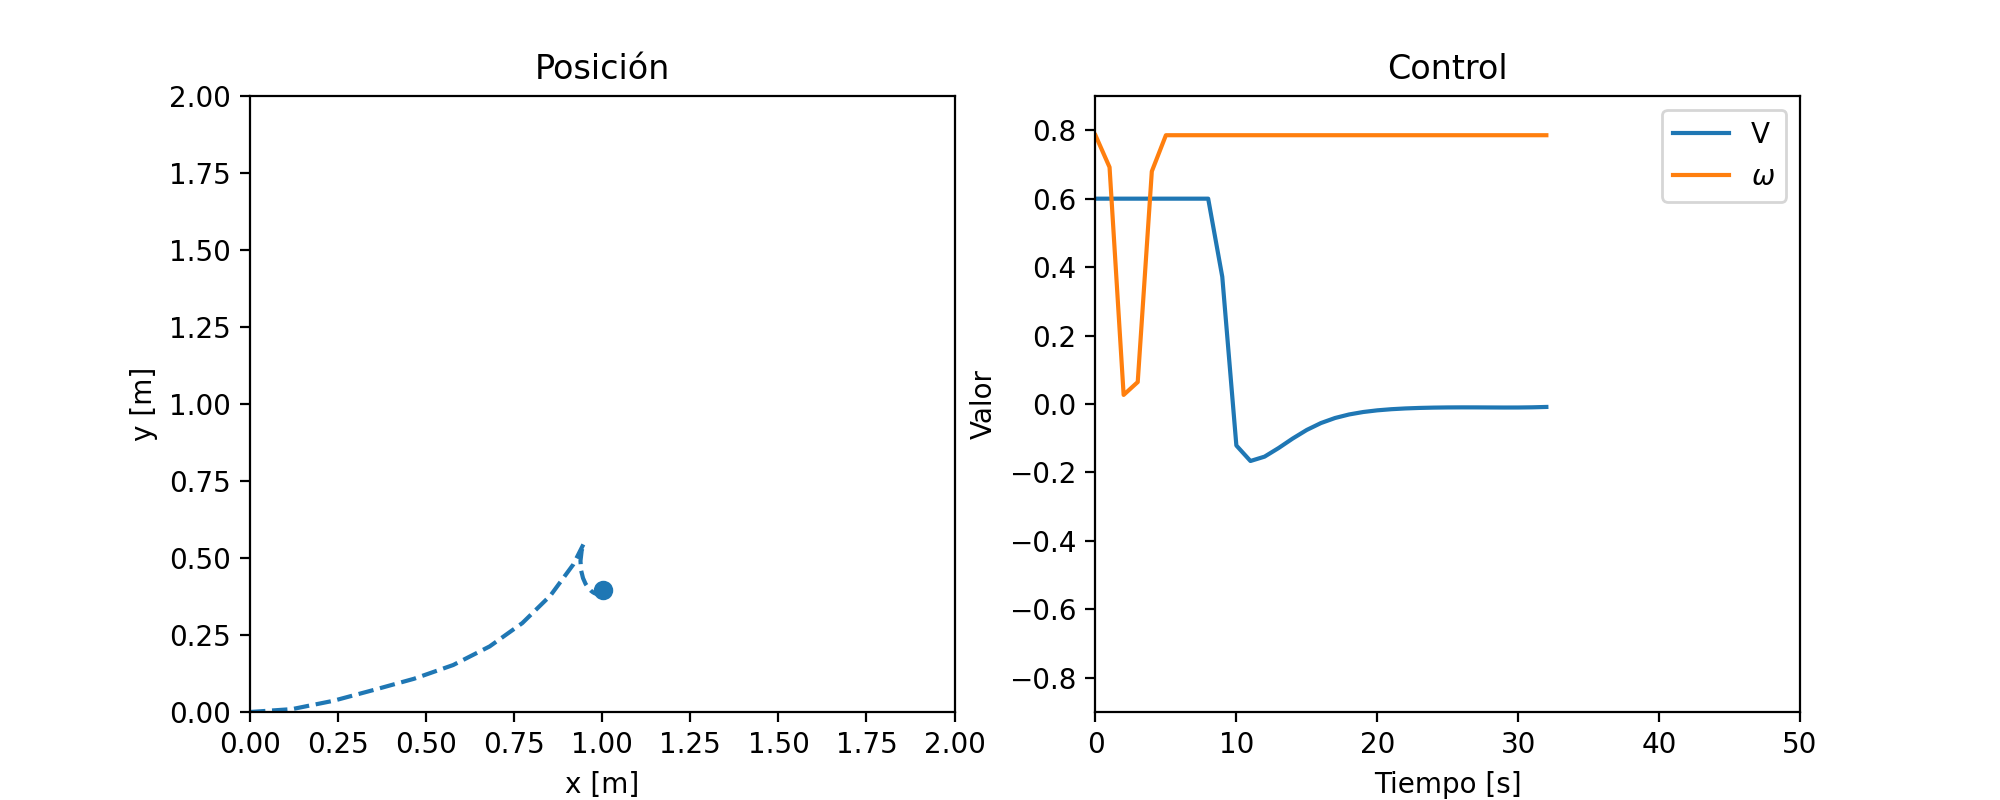

In [85]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def update(i):
    ax.clear()
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.plot(val_x_[:i], val_y_[:i],linestyle="dashed" )
    ax.scatter(val_x_[i], val_y_[i])
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_title("Posición")
    ax1.clear()
    ax1.set_xlim(0, 50)
    ax1.set_ylim(-0.9, 0.9)
    ax1.plot(val_u1[:i], label = "V")
    ax1.plot(val_u2[:i], label="$\omega$")
    ax1.legend()
    ax1.set_xlabel("Tiempo [s]")
    ax1.set_ylabel("Valor")
    ax1.set_title("Control")
    

Animation = anim.FuncAnimation(fig, update, frames=len(val_x_))

Punto en $[2,2,5]$

In [90]:
xr = np.array([1.25, 2, -10])

funcion = Q1 * sumsqr(x_p - xr[0]) + Q2 * sumsqr(y_p - xr[1]) + Q3 * sumsqr(a - xr[2]) + R1 * sumsqr(v) + R2 * sumsqr(w)
opti.minimize(funcion)
opti.set_value(x0, [0, 0, 0])


opti.solver('ipopt', {"print_time":False}, {"print_level":0})
sol = opti.solve()
_mpc_ = opti.to_function('mpc_step', [x0, opti.x, opti.lam_g], [U[:, 0], opti.x, opti.lam_g])
u = sol.value(U[:, 0])
x = sol.value(opti.x)
lam = sol.value(opti.lam_g)


val_x = DM.zeros(nx, 40)
val_u = DM.zeros(nu, 40)
x_i = vertcat(0, 0, 0)

for i in range(40):
    val_x[:, i] = x_i
    val_u[:, i] = u
    x_i = F(x_i, u)
    [u, x, lam] = _mpc_(x_i, x, lam)
    
val_x_ = np.squeeze(val_x[0,:])
val_y_ = np.squeeze(val_x[1,:])
val_u1 = np.squeeze(val_u[0,:])
val_u2 = np.squeeze(val_u[1,:])

<IPython.core.display.Javascript object>


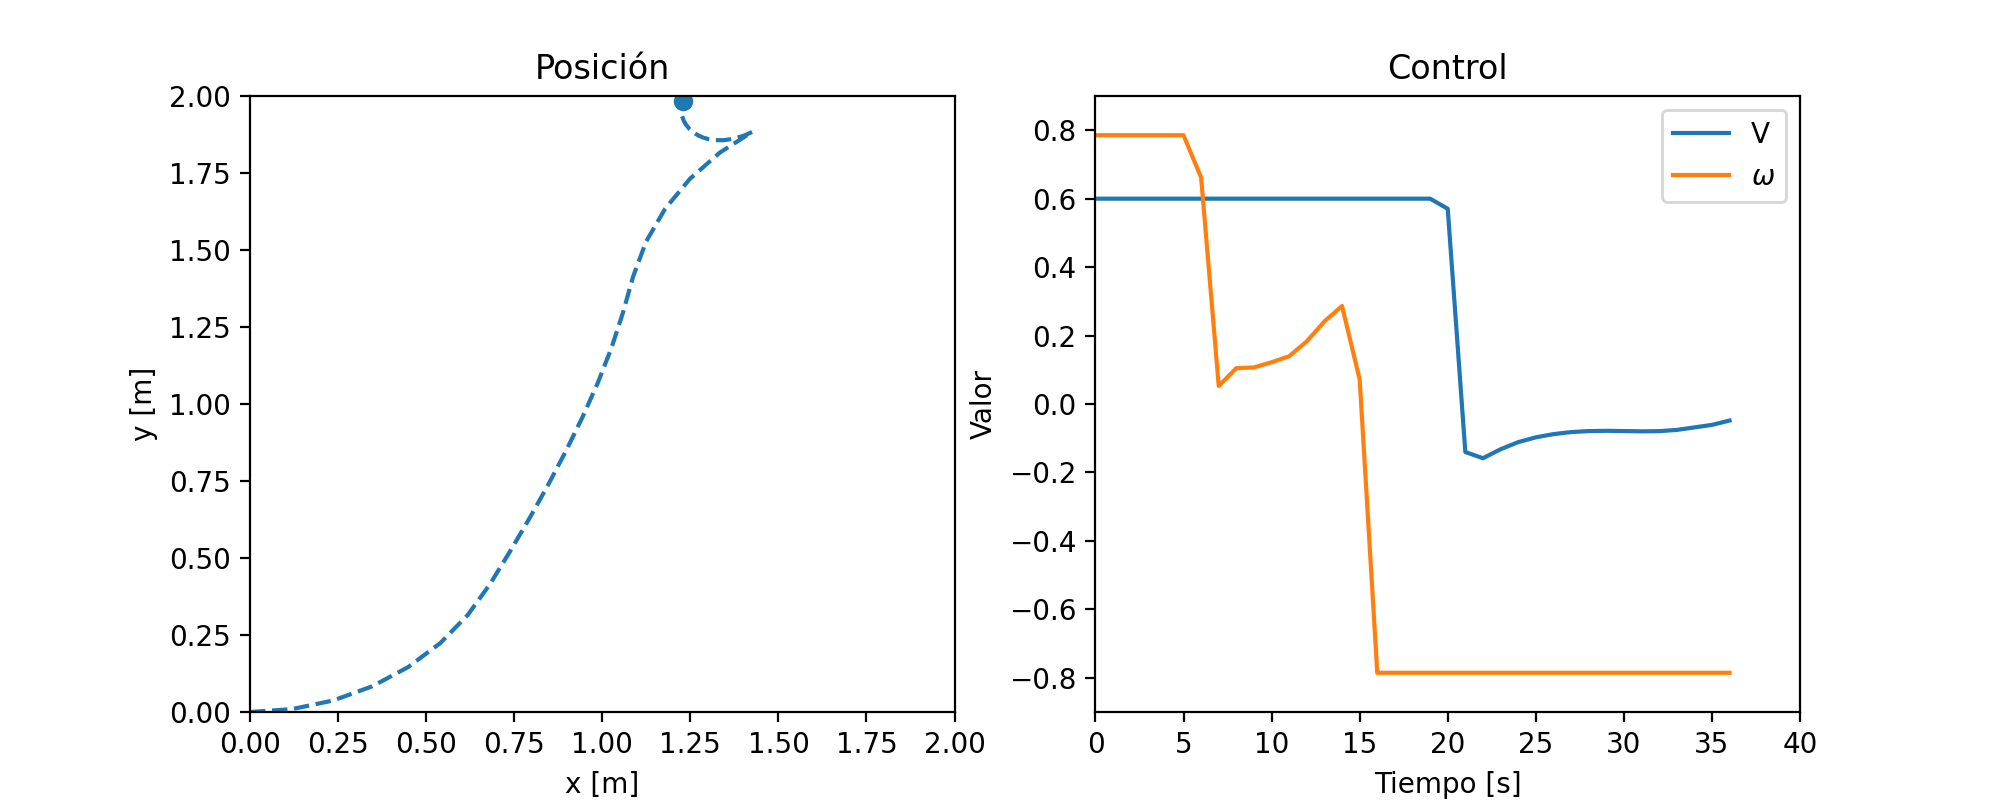

In [92]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def update(i):
    ax.clear()
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.plot(val_x_[:i], val_y_[:i],linestyle="dashed" )
    ax.scatter(val_x_[i], val_y_[i])
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_title("Posición")
    ax1.clear()
    ax1.set_xlim(0, 40)
    ax1.set_ylim(-0.9, 0.9)
    ax1.plot(val_u1[:i], label = "V")
    ax1.plot(val_u2[:i], label="$\omega$")
    ax1.legend()
    ax1.set_xlabel("Tiempo [s]")
    ax1.set_ylabel("Valor")
    ax1.set_title("Control")
    

Animation = anim.FuncAnimation(fig, update, frames=len(val_x_))

c.

## Punto 3. 

In [150]:
gamma1 = gamma2 = 0.4
A1 = A2 = 50.27
A3 = A4 = 28.27
a1 = 0.233
a2 = 0.242
a3 = a4 = 0.127
g = 980 #cm/s

Q = (3,3,0.03,0.03)
R = (0.0033, 0.0033)

xr =np.array([13.98,14.06,14.25,21.42])

x = MX.sym('x', 4)
u = MX.sym('u', 2)

dx1 = -(a1/A1)*sqrt(fmax(2*g*x[0],0.001))+a3/A1*sqrt(fmax(2*g*x[2],0.001))+gamma1/A1*u[0]
dx2 = -(a2/A2)*sqrt(fmax(2*g*x[1],0.001))+a4/A2*sqrt(fmax(2*g*x[3],0.001))+gamma2/A2*u[1]
dx3 = -(a3/A4)*sqrt(fmax(2*g*x[2],0.001))+(1-gamma2)/A3*u[1]
dx4 = -(a4/A4)*sqrt(fmax(2*g*x[3],0.001))+(1-gamma1)/A4*u[0]


func = vertcat(dx1,dx2,dx3,dx4)
f = Function('f', [x, u], [func])

In [151]:
int_opt = {"number_of_finite_elements":1,"tf":3}
intg = integrator('intg', 'rk', {'x':x,'p': u, 'ode': f(x,u)}, int_opt)
r = intg(x0 = x, p = u)
F = Function('F', [x, u], [r['xf']])

In [152]:
opti = Opti()
X = opti.variable(4, 20+1)
U = opti.variable(20, 2)
# Tanques
h1 = X[0,:]
h2 = X[1,:]
h3 = X[2,:]
h4 = X[3,:]

# Contorl
u1 = U[:,0]
u2 = U[:,1]
opti.subject_to(u1<60)
opti.subject_to(u2<60)

#valores iniciales
x0 = opti.parameter(4)
opti.subject_to(X[:,0] == x0)
opti.set_value(x0,vertcat(2,2,2,2))
xi = vertcat(2,2,2,2)

In [153]:
for k in range(20):
    opti.subject_to(X[:,k+1] == F(X[:,k],U[k,:]))

In [178]:
def solucion(Q,R,x_i,xr):
    Q1, Q2, Q3, Q4 = Q
    R1, R2 = R
    xr1,xr2,xr3,xr4 = xr 
    
    xval = DM.zeros(4,40)
    uval = DM.zeros(2,40)
    x_i = x_i
    
    
    function = (Q1* sumsqr(h1-xr1)+ Q2*sumsqr(h2-xr2)+ Q3*sumsqr(h3-xr3)+  Q4*sumsqr(h4-xr4))+ (R1*sumsqr(u1)+ R2*sumsqr(u2)) 
    opti.minimize(function)
    opti.set_value(x0,xi)
    opt_1 = dict(print_time=False)
    opt_2 = dict(print_level=0)
    opti.solver('ipopt',opt_1,opt_2)
    solution = opti.solve()
    _mpc_ = opti.to_function('mpc_step',[x0, opti.x, opti.lam_g],[U[0,:], opti.x, opti.lam_g])
    u = solution.value(U[0,:])
    x = solution.value(opti.x)
    l = solution.value(opti.lam_g)

    for i in range(40):
        xval[:,i] = x_i
        uval[:,i] = u

        x_i = F(x_i,u)
        [u,x,lam] = _mpc_(x_i,x,l)
    return  xval.T,uval.T

Gráficas de las siguientes condiciones: 

$$
Q = \begin{bmatrix}
3 & 0 & 0 & 0 \\
0 & 3 & 0 & 0 \\
0 & 0 & 0.03 & 0 \\
0 & 0 & 0 & 0.03 \\
\end{bmatrix}
$$
$$
R = 
\begin{bmatrix}
0.0033 & 0 \\
0 & 0.0 033 \\
\end{bmatrix}
$$

In [179]:
x_val, u_val = solucion(Q,R,xi,xr)

Text(0.5, 0, 'Tiempo [t]')

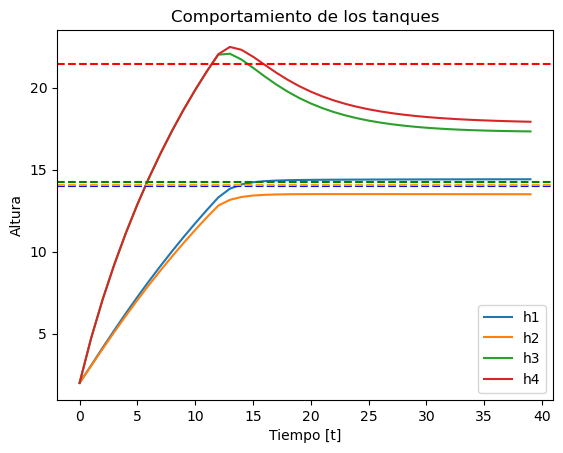

In [180]:
plt.plot(x_val)
plt.legend(["h1", "h2", "h3","h4"])
plt.axhline(y=13.98, color='b', linestyle='--')
plt.axhline(y=14.06, color='orange', linestyle='--')
plt.axhline(y=14.25, color='green', linestyle='--')
plt.axhline(y=21.42, color='r', linestyle='--')
plt.title("Comportamiento de los tanques")
plt.ylabel("Altura")
plt.xlabel("Tiempo [t]")

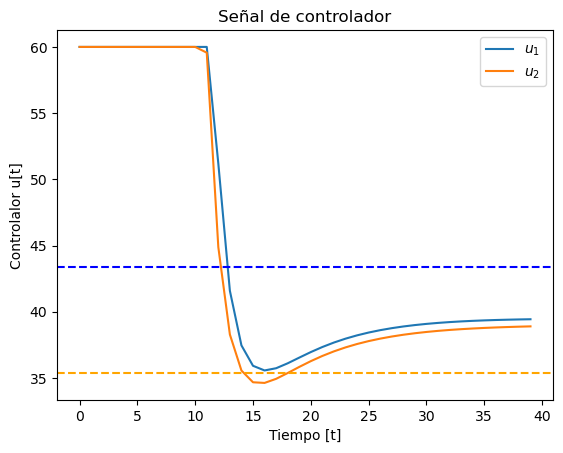

In [173]:
plt.plot(u_val)
plt.axhline(y=43.4, color='b', linestyle='--')
plt.axhline(y=35.4, color='orange', linestyle='--')
plt.title('Señal de controlador')
plt.ylabel('Controlalor u[t]')
plt.xlabel('Tiempo [t]')
plt.legend(["$u_1$", "$u_2$"])

Gráficas de las siguientes condiciones: 

$$
Q = \begin{bmatrix}
6 & 0 & 0 & 0 \\
0 & 6 & 0 & 0 \\
0 & 0 & 0.03 & 0 \\
0 & 0 & 0 & 0.03 \\
\end{bmatrix}
$$
$$
R = 
\begin{bmatrix}
0.0033 & 0 \\
0 & 0.0 033 \\
\end{bmatrix}
$$

In [158]:
Q1 = (6,6,0.03,0.03)
R1 = (0.005, 0.005)
x_val, u_val = solucion(Q1,R1,xi,xr)

Text(0.5, 0, 'Tiempo [t]')

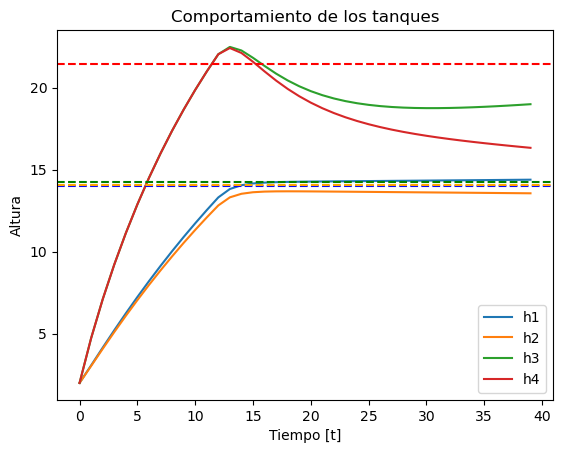

In [159]:
plt.plot(x_val)
plt.axhline(y=13.98, color='b', linestyle='--')
plt.axhline(y=14.06, color='orange', linestyle='--')
plt.axhline(y=14.25, color='green', linestyle='--')
plt.axhline(y=21.42, color='r', linestyle='--')
plt.legend(["h1", "h2", "h3","h4"])
plt.title("Comportamiento de los tanques")
plt.ylabel("Altura")
plt.xlabel("Tiempo [t]")

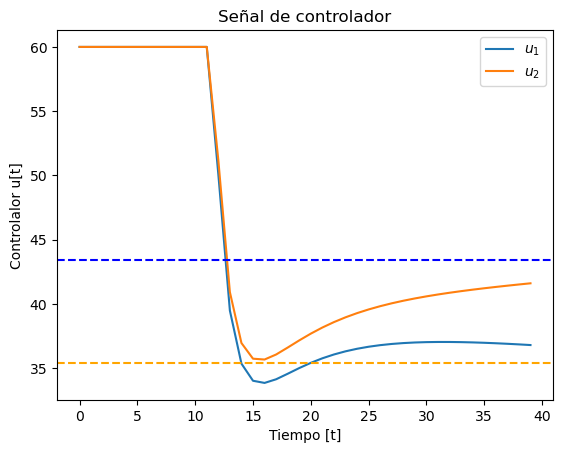

In [160]:
plt.plot(u_val)
plt.axhline(y=43.4, color='b', linestyle='--')
plt.axhline(y=35.4, color='orange', linestyle='--')
plt.title('Señal de controlador')
plt.ylabel('Controlalor u[t]')
plt.xlabel('Tiempo [t]')
plt.legend(["$u_1$", "$u_2$"])

Gráficas de las siguientes condiciones: 

$$
Q = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0.03 & 0 \\
0 & 0 & 0 & 0.03 \\
\end{bmatrix}
$$
$$
R = 
\begin{bmatrix}
0.0033 & 0 \\
0 & 0.0 033 \\
\end{bmatrix}
$$

In [161]:
Q2 = (1,1,0.03,0.03)
R2 = (0.0033, 0.0033)
x_val, u_val = solucion(Q2,R2,xi,xr)

Text(0.5, 0, 'Tiempo [t]')

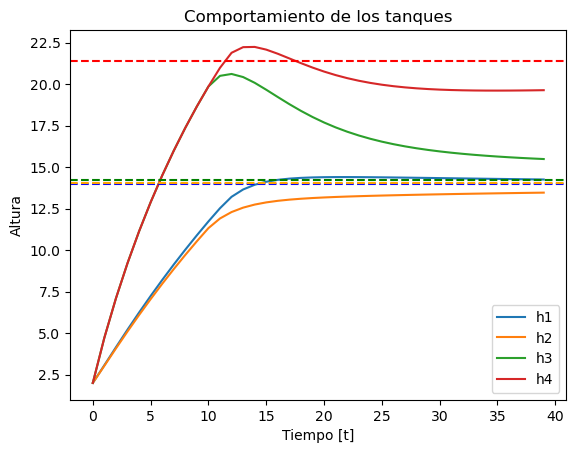

In [162]:
plt.plot(x_val)
plt.axhline(y=13.98, color='b', linestyle='--')
plt.axhline(y=14.06, color='orange', linestyle='--')
plt.axhline(y=14.25, color='green', linestyle='--')
plt.axhline(y=21.42, color='r', linestyle='--')
plt.legend(["h1", "h2", "h3","h4"])
plt.title("Comportamiento de los tanques")
plt.ylabel("Altura")
plt.xlabel("Tiempo [t]")

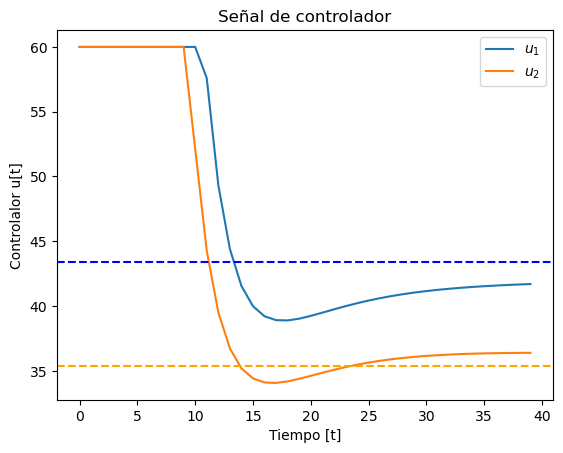

In [163]:
plt.plot(u_val)
plt.axhline(y=43.4, color='b', linestyle='--')
plt.axhline(y=35.4, color='orange', linestyle='--')
plt.title('Señal de controlador')
plt.ylabel('Controlalor u[t]')
plt.xlabel('Tiempo [t]')
plt.legend(["$u_1$", "$u_2$"])

Gráficas de las siguientes condiciones: 

$$
Q = \begin{bmatrix}
3 & 0 & 0 & 0 \\
0 & 3 & 0 & 0 \\
0 & 0 & 0.03 & 0 \\
0 & 0 & 0 & 0.03 \\
\end{bmatrix}
$$
$$
R = 
\begin{bmatrix}
0.001 & 0 \\
0 & 0.001 \\
\end{bmatrix}
$$

In [164]:
Q2 = (3,3,0.03,0.03)
R2 = (0.001, 0.001)
x_val, u_val = solucion(Q2,R2,xi,xr)

Text(0.5, 0, 'Tiempo [t]')

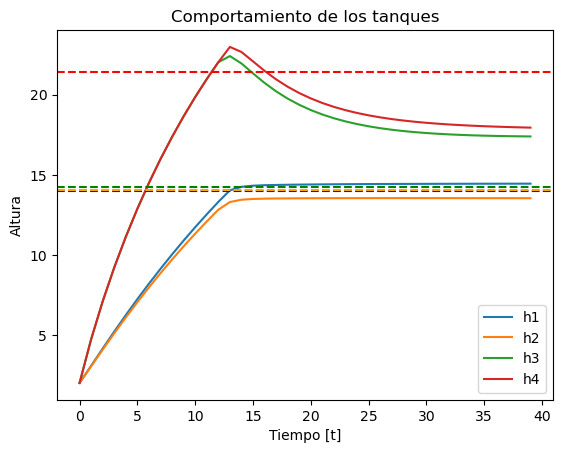

In [165]:
plt.plot(x_val)
plt.axhline(y=13.98, color='b', linestyle='--')
plt.axhline(y=14.06, color='orange', linestyle='--')
plt.axhline(y=14.25, color='green', linestyle='--')
plt.axhline(y=21.42, color='r', linestyle='--')
plt.legend(["h1", "h2", "h3","h4"])
plt.title("Comportamiento de los tanques")
plt.ylabel("Altura")
plt.xlabel("Tiempo [t]")

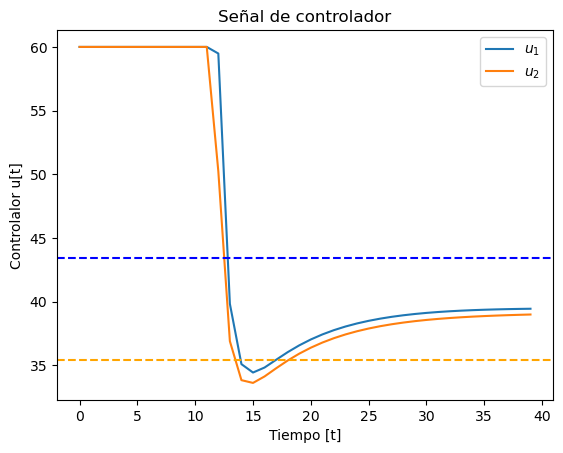

In [166]:
plt.plot(u_val)
plt.axhline(y=43.4, color='b', linestyle='--')
plt.axhline(y=35.4, color='orange', linestyle='--')
plt.title('Señal de controlador')
plt.ylabel('Controlalor u[t]')
plt.xlabel('Tiempo [t]')
plt.legend(["$u_1$", "$u_2$"])

Gráficas de las siguientes condiciones: 

$$
Q = \begin{bmatrix}
3 & 0 & 0 & 0 \\
0 & 3 & 0 & 0 \\
0 & 0 & 3 & 0 \\
0 & 0 & 0 & 3 \\
\end{bmatrix}
$$
$$
R = 
\begin{bmatrix}
0.1 & 0 \\
0 & 0.1 \\
\end{bmatrix}
$$

In [167]:
Q2 = (3,3,3,3)
R2 = (0.1, 0.1)

x_val, u_val = solucion(Q2,R2,xi,xr)

Text(0.5, 0, 'Tiempo [t]')

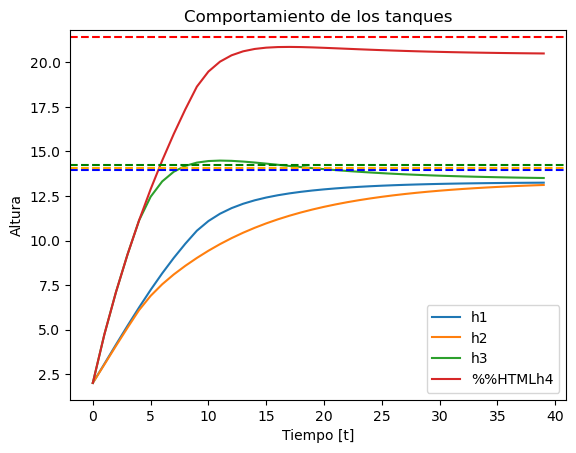

In [168]:
plt.plot(x_val)
plt.axhline(y=13.98, color='b', linestyle='--')
plt.axhline(y=14.06, color='orange', linestyle='--')
plt.axhline(y=14.25, color='green', linestyle='--')
plt.axhline(y=21.42, color='r', linestyle='--')
plt.legend(["h1", "h2", "h3","%%HTMLh4"])
plt.title("Comportamiento de los tanques")
plt.ylabel("Altura")
plt.xlabel("Tiempo [t]")

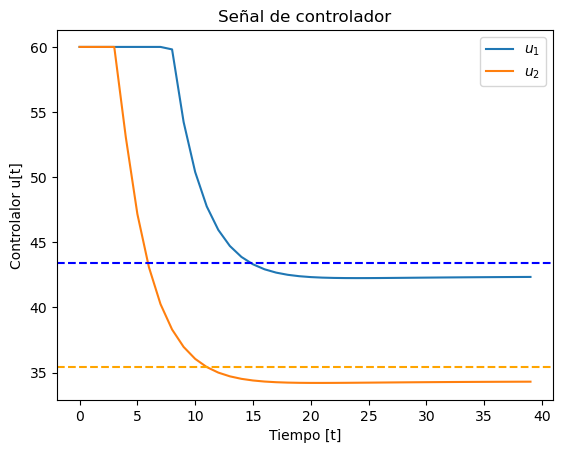

In [169]:
plt.plot(u_val)
plt.axhline(y=35.4, color='orange', linestyle='--')
plt.axhline(y=43.4, color='blue', linestyle='--')
plt.title('Señal de controlador')
plt.ylabel('Controlalor u[t]')
plt.xlabel('Tiempo [t]')
plt.legend(["$u_1$", "$u_2$"])

Considerando los diferentes valores de las matrices de costos Q y R, y queriendo llegar a los valores de establecimiento: 
$$
x_r = 
\begin{bmatrix}
13.98 \\
14.06  \\
14.25 \\
21.42
\end{bmatrix} \,u_r = 
\begin{bmatrix}
43.4 \\
35.4 \\
\end{bmatrix}
$$

Lo cual, se puede observar que para diferentes valores del costo matricial no genera estabilidad del sistema deseado en el tiempo requerido. No obstante, hay otras combinaciones de valores que genera esta estabilidad, siendo el caso para 
$$
Q = \begin{bmatrix}
3 & 0 & 0 & 0 \\
0 & 3 & 0 & 0 \\
0 & 0 & 3 & 0 \\
0 & 0 & 0 & 3 \\
\end{bmatrix}
\,
R = 
\begin{bmatrix}
0.1 & 0 \\
0 & 0.1 \\
\end{bmatrix}
$$


En el cual, si el valor se encuentra más grande para alguna variable podemos notar que se encuentra un mayor control de esta.  